# **SVM x Decision Trees x Random Forest Performance Comparison**
by Dominador G. Dano Jr.

## **Dataset Description**

In [117]:
import pandas as pd

data = pd.read_csv('data/onlinefoods.csv')
data.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,Pin code,Output,Feedback
0,20,Female,Single,Student,No Income,Post Graduate,4,560001,Yes,Positive
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,560009,Yes,Positive
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,560017,Yes,Negative
3,22,Female,Single,Student,No Income,Graduate,6,560019,Yes,Positive
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,560010,Yes,Positive


In [118]:
data.describe()

,Age,Family size,Pin code
count,388.000000,388.000000,388.000000
mean,24.628866,3.280928,560040.113402
std,2.975593,1.351025,31.399609
min,18.000000,1.000000,560001.000000
25%,23.000000,2.000000,560010.750000
50%,24.000000,3.000000,560033.500000
75%,26.000000,4.000000,560068.000000
max,33.000000,6.000000,560109.000000


## **Outlier Detection**
IQR outlier detection for continuous columns


Outliers detected using IQR method:
Series([], Name: Age, dtype: int64)


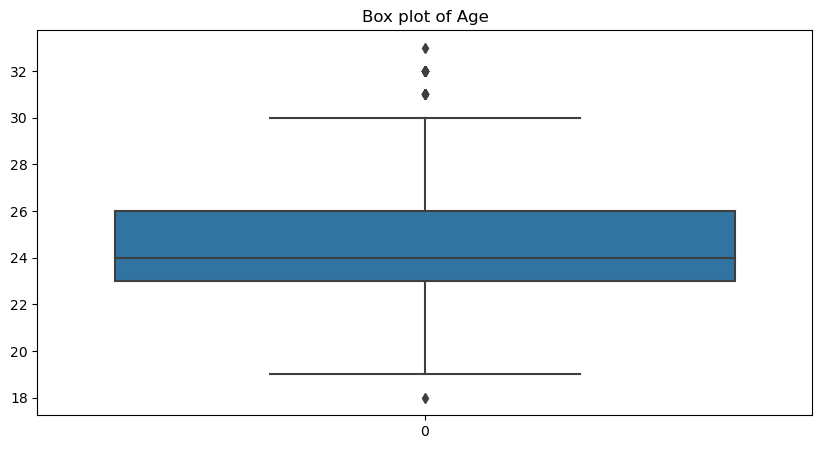

In [119]:
# Outlier Detection
import numpy as np
from scipy.stats import zscore

# Select the column you want to analyze
column_name = 'Age'  # replace with the actual column name
selected_data = data[column_name]

# IQR method
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.05)
    Q3 = data.quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

# Detect outliers using both methods
outliers_iqr = detect_outliers_iqr(selected_data)

# Print outliers
print("\nOutliers detected using IQR method:")
print(outliers_iqr)

# Visualize outliers using a box plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.boxplot(selected_data)
plt.title(f'Box plot of {column_name}')
plt.show()


## **Binning and Label Encoding**
Data is binned to be used for feature selection, since Chi Square Test and Cramer's V requires the columns to be categorical

In [120]:
# Manually bin columns
binned_age = pd.cut(data["Age"],
            bins=[17, 22, 26, 29, 34],
            labels=['1', '2', '3', '4'])

binned_pinCode =  pd.cut(data["Pin code"],
            bins=[560000, 560025, 560050, 560075, 560100, 560125],
            labels=['1', '2', '3', '4', '5'])


# Label encode all columns except manually binned columns
from library.bin import label_encode_all
data = label_encode_all(data, exclude_columns=['Age', 'Pin code'])


# Replace the original columns
data['Age'] = binned_age
data['Pin code'] = binned_pinCode

# Show new data
data.head()


,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,Pin code,Output,Feedback
0,1,0,2,3,4,2,3,1,1,1
1,2,0,2,3,2,0,2,1,1,1
2,1,1,2,3,2,2,2,1,1,0
3,1,0,2,3,4,0,5,1,1,1
4,1,1,2,3,2,2,3,1,1,1


## **Feature Selection**

### X vs X Feature Selection Using Cramer's V

Cramér's V is a measure of association between two categorical variables. It's based on the chi-square statistic and ranges from 0 to 1, with 0 indicating no association and 1 indicating a perfect association.

Cramer's V Coefficient • *source: IBM - https://www.ibm.com/docs/en/cognos-analytics/12.0.0?topic=terms-cramrs-v*

- > <= 0.2 - The result is weak. Although the result is statistically significant, the fields are only weakly associated.

- > <= 0.6 - The result is moderate. The fields are moderately associated.

- > 0.6 and above - The result is strong. The fields are strongly associated.


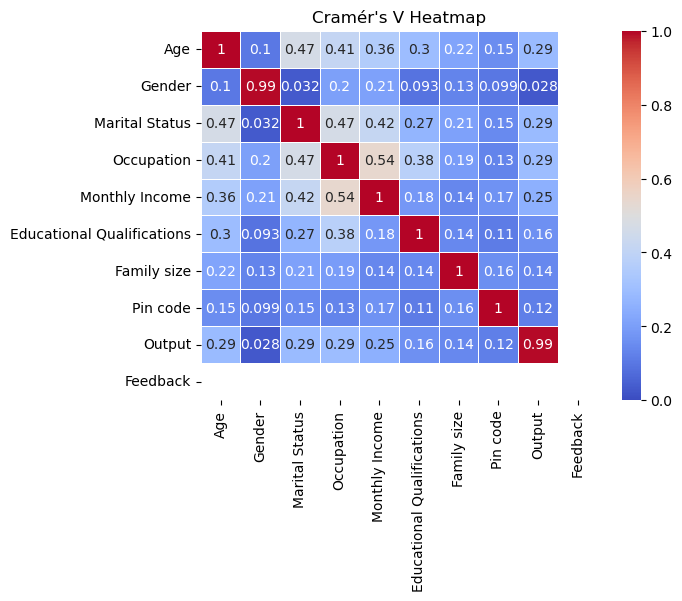

({('Age', 'Age'): 1.0,
  ('Family size', 'Family size'): 0.9999999999999999,
  ('Gender', 'Gender'): 0.9947356995549765,
  ('Output', 'Output'): 0.9925917439951121,
  ('Monthly Income', 'Occupation'): 0.5420432625936349,
  ('Age', 'Marital Status'): 0.467781395310831,
  ('Occupation', 'Marital Status'): 0.4676466238039181,
  ('Monthly Income', 'Marital Status'): 0.4160984534015246,
  ('Marital Status', 'Monthly Income'): 0.41609845340152457,
  ('Occupation', 'Age'): 0.41295525793930893},
     Age  Gender  Marital Status  Occupation  Monthly Income  \
 0     1       0               2           3               4   
 1     2       0               2           3               2   
 2     1       1               2           3               2   
 3     1       0               2           3               4   
 4     1       1               2           3               2   
 ..   ..     ...             ...         ...             ...   
 383   2       0               2           3               

In [121]:
from library.feature_selection import cramers_v_analysis
cramers_v_analysis(data, target_column='Feedback', threshold=0.6, top_n=10, plot=True, figsize=None)

## X vs Y Feature Selection using Chi Square Test



In [122]:
from library.feature_selection import chi2_feature_significance

chi2_feature_significance(data, "Feedback", significance_threshold=0.05)

,Feature,Significance,p-value
8,Output,Significant,0.0
4,Monthly Income,Significant,0.000008
3,Occupation,Significant,0.000082
2,Marital Status,Significant,0.000191
0,Age,Significant,0.006042
5,Educational Qualifications,Significant,0.029317
7,Pin code,Not Significant,0.405208
1,Gender,Not Significant,0.445289
6,Family size,Not Significant,0.696247



## **Accuracy Comparison**

Initial Model Creation with SMOTE for Comparison 

In [123]:
from library.model import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

x = data.drop(columns=['Feedback'], axis=1)
x.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,Pin code,Output
0,1,0,2,3,4,2,3,1,1
1,2,0,2,3,2,0,2,1,1
2,1,1,2,3,2,2,2,1,1
3,1,0,2,3,4,0,5,1,1
4,1,1,2,3,2,2,3,1,1


In [124]:
y = data['Feedback']
y.head()

0    1
1    1
2    0
3    1
4    1
Name: Feedback, dtype: int64

### **Balancing the data**

In [125]:
x_smote, y_smote = balance_data(x, y)

# X with feature selection
x_smote_featureSelection = x_smote.drop(['Family size', 'Gender', 'Pin code',], axis=1)

### **Decision Trees**

In [126]:
decision_tree_model = DecisionTreeClassifier(random_state=42);

tabulize_model_results(decision_tree_model, "Decision Tree", x_smote, y_smote )

,Accuracy,F1-score,Precision,Mean Squared Error,Mean Absolute Error
Decision Tree,0.889764,0.889887,0.893984,0.110236,0.110236


In [127]:
tabulize_model_results(decision_tree_model, "Decision Tree (feature selection)", x_smote_featureSelection, y_smote )

,Accuracy,F1-score,Precision,Mean Squared Error,Mean Absolute Error
Decision Tree (feature selection),0.866142,0.866291,0.867408,0.133858,0.133858


### **Random Forest**

In [128]:
random_forest_model = RandomForestClassifier(random_state=42);
tabulize_model_results(random_forest_model,"Random Forest", x_smote, y_smote,)

,Accuracy,F1-score,Precision,Mean Squared Error,Mean Absolute Error
Random Forest,0.889764,0.889887,0.893984,0.110236,0.110236


In [129]:
tabulize_model_results(random_forest_model,"Random Forest with feature selection", x_smote_featureSelection, y_smote,)

,Accuracy,F1-score,Precision,Mean Squared Error,Mean Absolute Error
Random Forest with feature selection,0.874016,0.874125,0.874669,0.125984,0.125984


### **Support Vector Machines (SVM)**

In [130]:
svm_model = SVC(random_state=42);
tabulize_model_results(svm_model, "Support Vector Machines", x_smote, y_smote)

,Accuracy,F1-score,Precision,Mean Squared Error,Mean Absolute Error
Support Vector Machines,0.84252,0.84252,0.84252,0.15748,0.15748


In [131]:
tabulize_model_results(svm_model, "Support Vector Machines with feature selection", x_smote_featureSelection, y_smote)

,Accuracy,F1-score,Precision,Mean Squared Error,Mean Absolute Error
Support Vector Machines with feature selection,0.834646,0.834273,0.834842,0.165354,0.165354
